# <span style="color:blue">**Capítulo 15**</span>
## <font color=blue size=8> Clustering de Propagación por Afinidad </font>
### Un algoritmo estilo chisme para la agrupación

## En Pocas Palabras

En las redes sociales, cuando un conjunto enorme de personas se reúne, dividimos el conjunto completo formando grupos. Cada grupo tiene un líder designado, y los miembros de cada grupo tienen cierta afinidad entre sí y con su líder. Los grupos se crean mediante mensajería entre pares. Es decir, cada miembro conversa con otros para decidir si sus intereses coinciden, a quién prefieren más como líder del grupo, la disponibilidad de la persona para aceptar las responsabilidades de un líder, etc., para formar los grupos. La misma idea se aplica al diseñar la agrupación por propagación de afinidad (*affinity propagation clustering*). El algoritmo no requiere que determines de antemano el número de agrupaciones que se formarán.

## Funcionamiento del Algoritmo

Como entrada para el algoritmo, primero debemos determinar la similitud entre los puntos de datos. Calculamos la matriz de similitud:

Consideremos un conjunto de datos de $n$ puntos $d_1, ..., d_n$.  
La matriz de similitud es una matriz de $n \times n$ donde cada punto $s(i, j)$ representa la similitud entre $d_i$ y $d_j$. La propia $s$ se define como:

$$
s(i, j) = -\|x_i - x_j\|^2
$$

donde $x_i$ y $x_j$ son los dos puntos.

La diagonal de la matriz, es decir, $s(i, i)$, determina cuán probable es que una entrada particular se convierta en un ejemplar (un líder para formar el grupo).  

Con la entrada anterior, el algoritmo procede alternando entre dos pasos de paso de mensajes, actualizando dos matrices llamadas responsabilidad (*responsibility*) y disponibilidad (*availability*) en cada iteración, cada elemento $r(i, k)$ de la matriz de responsabilidad (*responsibility matrix*) cuantifica qué tan adecuado es $x_k$ para ser un ejemplar de $x_i$, en comparación con otros ejemplares candidatos para $x_i$. Cada elemento $a(i, k)$ de la matriz de disponibilidad (*availability matrix*) representa la idoneidad de $x_k$ como ejemplar de $x_i$. Inicialmente, ambas matrices se inicializan con ceros. Luego, el algoritmo realiza actualizaciones en estas dos matrices de manera iterativa. Ejecutamos el algoritmo durante un número predefinido de iteraciones.

### Actualizaciones de la Matriz de Responsabilidad

Primero, la matriz de responsabilidad se actualiza usando la siguiente ecuación:

$$
r(i, k) \leftarrow s(i, k) - \max_{k' \ne k} \{ a(i, k') + s(i, k') \}
$$

donde $r(i, k)$ representa la responsabilidad de que el punto $k$ sea el ejemplar del punto $i$.  

¿Cómo se decide esto? El primer término es la similitud $s(i, k)$ entre los puntos $i$ y $k$. Un valor más alto de $s$ sugiere que $k$ podría ser el ejemplar de $i$. Sin embargo, esto no es suficiente para determinar la responsabilidad, ya que también es necesario considerar la idoneidad de otros puntos como ejemplares para $i$. Esto se determina mediante el segundo término en la ecuación anterior. El segundo término calcula el máximo de la suma entre la disponibilidad y la similitud de todas las demás muestras $k'$. Este valor máximo representa el mayor competidor para $k$. Restamos este valor del primer término para calcular su fuerza relativa como ejemplar.

### Actualizaciones de la Matriz de Disponibilidad

Cada término de la matriz de disponibilidad se define como:

$$
a(i, k) \leftarrow \min \left( 0, \; r(k, k) + \sum_{i' \ne i, k} \max(0, r(i', k)) \right)
$$

La disponibilidad se determina como el mínimo entre cero y el segundo término de la ecuación, que consta de dos partes. La primera parte, $r(k, k)$, determina la responsabilidad de $k$ hacia sí mismo, es decir, cuán importante se considera a sí mismo como ejemplar. La segunda parte calcula la suma de las responsabilidades de todas las demás muestras $i'$ hacia $k$, donde $i'$ no es ni $i$ ni $k$.  

En palabras simples, esto significa que una muestra será considerada como un posible ejemplar si ella misma piensa que es altamente importante y las otras muestras a su alrededor también lo creen.  
En cada iteración, actualizamos los puntajes utilizando las ecuaciones definidas anteriormente.

### Actualización de Puntajes

Los puntajes se actualizan utilizando las siguientes ecuaciones:

$$
r_{(t+1)}(i, k) = \lambda \cdot r_{(t)}(i, k) + (1 - \lambda) \cdot r_{(t+1)}(i, k)
$$

$$
a_{(t+1)}(i, k) = \lambda \cdot a_{(t)}(i, k) + (1 - \lambda) \cdot a_{(t+1)}(i, k)
$$

En cada actualización, la fracción $\lambda$ del valor antiguo se combina con $+(1 - \lambda)$ del nuevo valor. El parámetro $\lambda$ es un factor de suavizado (*smoothing factor*), también llamado valor de amortiguación (*damping value*), que asegura una transición suave. Después de un cierto número de iteraciones, detenemos el algoritmo y verificamos los grupos formados.

### Algunas observaciones

De las discusiones anteriores, se puede ver que el algoritmo es computacionalmente intensivo. La complejidad temporal es $O(n^2 \log n)$ y, por lo tanto, debería aplicarse solo a conjuntos de datos pequeños y medianos. El principal beneficio de este algoritmo es que estima el número de grupos por sí mismo. Es relativamente insensible a los valores atípicos (*outliers*).  

Aunque ofrece un rendimiento excelente en la mayoría de los casos, no se puede aplicar a conjuntos de datos no convexos, ya que fácilmente se queda atrapado en óptimos locales. Si no se establecen las preferencias adecuadas durante la agrupación, puede generar un conjunto de grupos mayor o menor al esperado. Por ello, se requiere un análisis cuidadoso de los puntajes de precisión para determinar el número más apropiado de grupos estimados. Este punto se explica en profundidad más adelante en el proyecto del capítulo.  

La *Hierarchical Affinity Propagation* es una variante que maneja la complejidad cuadrática de este algoritmo dividiendo el conjunto de datos en subconjuntos y luego realizando dos niveles de agrupación. Ahora discutiré su implementación tal como se proporciona en la biblioteca *sklearn*.

## Implementación

La biblioteca *sklearn* implementa el algoritmo de agrupación por propagación de afinidad en la clase `sklearn.cluster.AffinityPropagation`. Su uso es trivial:

```python
model = AffinityPropagation().fit(X)

Después de que el modelo agrupa tu conjunto de datos, obtienes el número de grupos encontrados usando este código:

```python
center_indices = model.cluster_centers_indices_
number_of_clusters = len(center_indices)

El modelo proporciona varios atributos más para determinar la homogeneidad de los grupos formados, la puntuación de completitud (completeness score), información mutua ajustada (adjusted mutual information), índice aleatorio ajustado (adjusted random index) e incluso el coeficiente de silueta (silhouette coefficient). Puedes usar estas métricas para determinar la calidad de la agrupación.

## Proyecto


Demostraré la aplicación del algoritmo de agrupación por propagación de afinidad en dos tipos de conjuntos de datos: un conjunto de datos aleatorio creado mediante codificación y un conjunto de datos de la vida real.  

In [156]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AffinityPropagation
from sklearn.datasets import make_blobs
from sklearn import metrics
import matplotlib.pyplot as plt
from itertools import cycle

El conjunto de datos aleatorio se crea usando la función habitual `make_blobs`: 

In [157]:
centers = [[1,1],[-1,-1],[1,-1]]
X, Y = make_blobs(
    n_samples=300, centers=centers, cluster_std=0.5, random_state=0
)

La figura 15.1 muestra la distribución de los datos en mi ejecución de prueba.

C:\Users\HP\AppData\Local\Temp\ipykernel_20688\2643762548.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], s=50, cmap='viridis', c='blue');


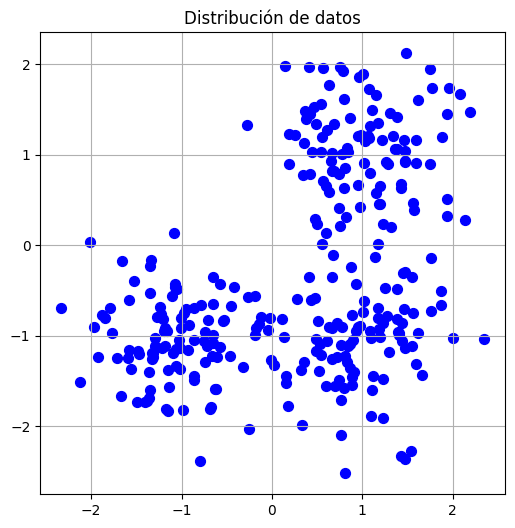

In [158]:
plt.rcParams["figure.figsize"] = (6, 6)   
plt.grid()
plt.title ('Distribución de datos')
plt.scatter(X[:, 0], X[:, 1], s=50, cmap='viridis', c='blue');

<p style="color:blue; margin-top: 5px; font-weight: bold;">Fig. 15.1</p>

<p>Conjunto de datos aleatorio.</p>

Aplicamos el algoritmo usando la siguiente instrucción:

In [159]:
model = AffinityPropagation(preference=-50).fit(X)

Observa que he establecido un parámetro llamado `preference` en la instrucción anterior. El valor de este parámetro juega un papel importante en la creación de grupos. Mostraré en breve el efecto de cambiar el valor de este parámetro. Con valores más grandes para este parámetro, aumenta el número de ejemplares y, por lo tanto, el número de grupos. Cuando no especificas este parámetro en la llamada a la función, se utiliza la mediana de las similitudes de entrada como preferencia para cada punto.  

In [160]:
center_indices = model.cluster_centers_indices_
number_of_clusters = len(center_indices)
print("Estimated number of clusters: %d" % number_of_clusters)

number_of_clusters = len(center_indices)

Estimated number of clusters: 3


Después de que el modelo realiza la agrupación, determinamos el número de grupos contando los ejemplares. Verificamos la homogeneidad usando el atributo `homogeneity_score`, dónde se obtiene un valor de la homogeneidad:

In [161]:
labels = model.labels_
print("Homogeneity: %0.3f" % metrics.homogeneity_score(Y, labels))

Homogeneity: 0.872


Este valor me da la confianza de que la calidad de la agrupación es realmente buena. 

Puedes revisar el arreglo `labels` para entender la asociación de cada punto de datos a un grupo particular. La figura 15.2 muestra los valores de las etiquetas en mi ejecución de prueba.  

In [162]:
labels

array([0, 1, 2, 0, 0, 2, 1, 1, 2, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 2, 1, 2, 2, 1, 0, 2, 1, 2, 2, 2, 2, 0, 0, 0, 1, 0,
       2, 1, 1, 1, 1, 0, 0, 0, 1, 2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 1, 1, 1,
       2, 1, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 1, 2, 0, 1, 2, 2, 0, 0, 1,
       1, 0, 2, 0, 2, 0, 2, 0, 2, 1, 0, 1, 0, 0, 1, 0, 0, 2, 2, 1, 2, 2,
       2, 2, 2, 1, 0, 2, 0, 1, 2, 1, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 0, 1,
       1, 2, 0, 2, 0, 1, 2, 0, 1, 1, 2, 0, 1, 0, 2, 1, 2, 2, 2, 0, 0, 0,
       2, 0, 2, 0, 0, 0, 0, 1, 2, 0, 1, 1, 1, 2, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 2, 1, 0, 2, 1, 0, 2, 2, 2, 0, 1, 2, 1, 0, 1,
       0, 1, 0, 0, 1, 2, 2, 2, 2, 0, 1, 1, 0, 2, 2, 2, 0, 1, 0, 0, 1, 0,
       2, 2, 0, 2, 1, 1, 1, 0, 0, 2, 1, 1, 1, 2, 1, 0, 2, 2, 0, 2, 2, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 2, 0, 1, 1, 0, 2, 2, 2, 2, 0, 0, 0,
       0, 0, 1, 1, 2, 0, 0, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1,
       2, 0, 1, 2, 2, 1, 2, 2, 2, 1, 0, 2, 1, 1])

<p style="color:blue; margin-top: 5px; font-weight: bold;">Fig. 15.2</p>

<p>Asignaciones de clústeres para varios puntos de datos.</p>

Se observa que cada punto está asociado a uno de los grupos: 0, 1 o 2.  

Ahora puedes graficar el conjunto de datos agrupado con una rutina de trazado simple. El resultado de la ejecución de prueba se muestra en la figura 15.3.

In [163]:
def plot_clusters():  
  
  colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
  
  for k, col in zip(range(number_of_clusters), colors):
      class_members = labels == k
      cluster_center = X[center_indices[k]]
      plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
      plt.plot(
        cluster_center[0], 
        cluster_center[1], 
        'o',
        markerfacecolor = col, 
        markeredgecolor ='k',
        markersize = 10
      )
  
      for x in X[class_members]:

        plt.plot(
            [cluster_center[0], x[0]], 
            [cluster_center[1], x[1]], 
            col)
  
  plt.title('Número estimado de clústers: % d' % number_of_clusters)
  plt.show()

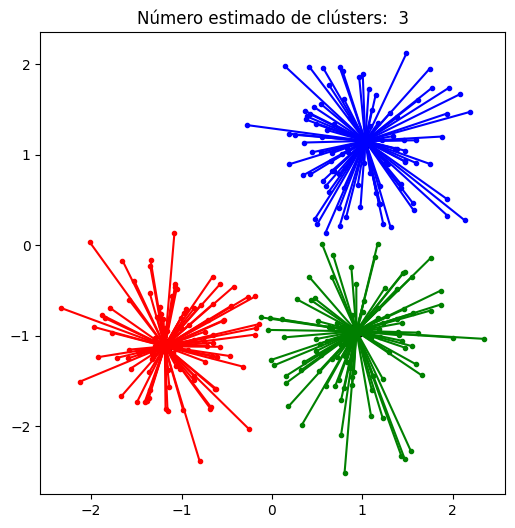

In [164]:
plot_clusters()

<p style="color:blue; margin-top: 5px; font-weight: bold;">Fig. 15.3</p>

<p>Clústeres creados por propagación por afinidad.</p>

A continuación, mostraré el efecto del valor del parámetro `preference` en la agrupación. Simplemente cambiaremos el valor del parámetro en la llamada a la función como se muestra en la siguiente instrucción y graficaremos los datos agrupados:

```python
model = AffinityPropagation(preference=-40).fit(X)

Los resultados de los diferentes valores de `preference` se muestran en la figura 15.4.

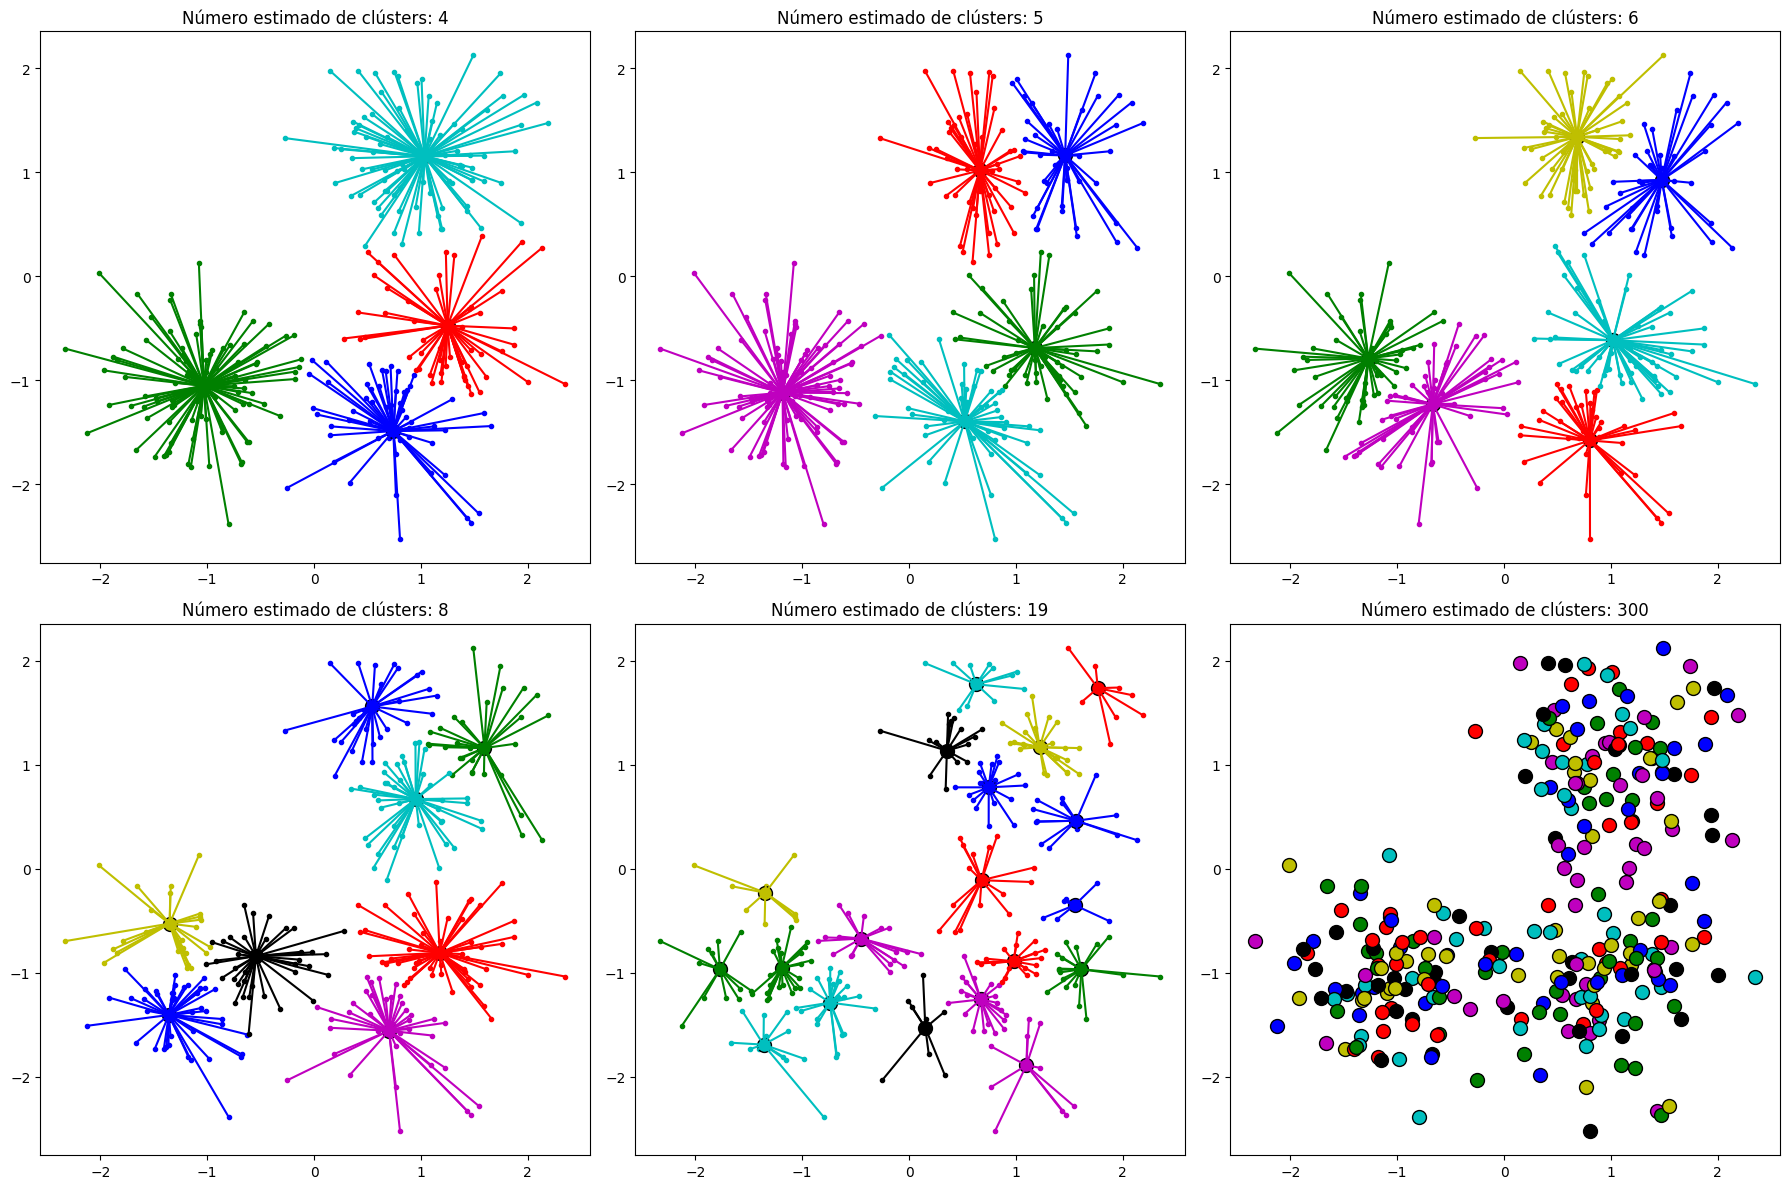

In [165]:
def plot_clusters_6(ax, X, labels, center_indices, number_of_clusters):
    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for k, col in zip(range(number_of_clusters), colors):
        class_members = labels == k
        cluster_center = X[center_indices[k]]
        ax.plot(X[class_members, 0], X[class_members, 1], col + '.')
        ax.plot(
            cluster_center[0], 
            cluster_center[1], 
            'o', 
            markerfacecolor=col,
            markeredgecolor='k', 
            markersize=10
        )
        for x in X[class_members]:
            ax.plot(
                [cluster_center[0], x[0]], 
                [cluster_center[1], x[1]], 
                col
            )
    ax.set_title('Número estimado de clústers: %d' % number_of_clusters)

preferences = [-40, -30, -20, -10, -2, 0] #Diferentes valores de `preference`
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, pref in enumerate(preferences):
    model = AffinityPropagation(preference=pref).fit(X) #Se asigna el efecto de los diferentes valores
    center_indices = model.cluster_centers_indices_
    number_of_clusters = len(center_indices)
    labels = model.labels_
    
    plot_clusters_6(axes[i], X, labels, center_indices, number_of_clusters)

plt.tight_layout()
plt.show()



<p style="color:blue; margin-top: 5px; font-weight: bold;">Fig. 15.4</p>

<p>Clustering para distintos valores de preferencia (`preference`).</p>

Como puedes ver, aumentar el valor de `preference` crea más grupos. Esto es bastante obvio; como mencioné antes, esos valores más grandes de `preference` hacen que cada punto compita por ser un ejemplar.  

El caso interesante de observar en el diagrama anterior es cuando `preference` se establece en 2. Con un valor tan grande, casi cada punto tiene una buena oportunidad de convertirse en ejemplar, por lo que 151 puntos de 300 se han convertido en ejemplares. 

El último y más importante caso es cuando establecemos `preference` en cero. Aquí, cada punto se ha convertido en ejemplar, como se observa en que el número de grupos formados es 300, que es el tamaño de nuestro conjunto de datos.  

Una última observación que me gustaría presentar es qué sucede cuando no se establece un valor para este parámetro. Como mencioné antes, en ese caso se usaría la mediana de las similitudes de entrada como valor para este parámetro. El resultado de usar este valor por defecto en mi ejecución de prueba se muestra en la figura 15.5.

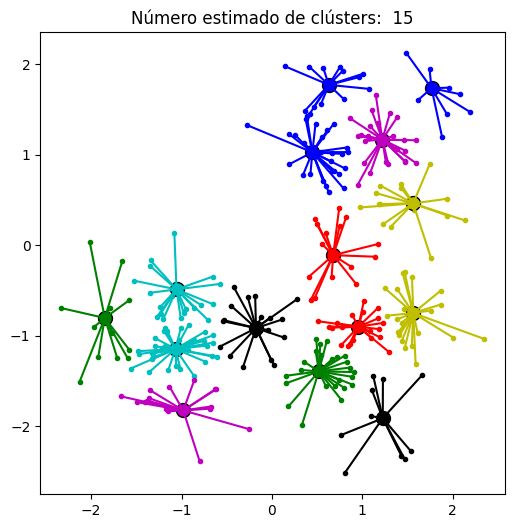

In [166]:
model = AffinityPropagation().fit(X)
center_indices = model.cluster_centers_indices_
number_of_clusters = len(center_indices)
labels = model.labels_
plot_clusters()

<p style="color:blue; margin-top: 5px; font-weight: bold;">Fig. 15.5</p>

<p>Clustering con valor predeterminado de preferencia (`preference`).</p>

Con el valor por defecto o predeterminado, el algoritmo ha formado 15 grupos en nuestro conjunto de datos, lo cual puede no ser correcto, ya que configuramos los *blobs* para tres grupos. Si hubiéramos proporcionado una mayor separación entre los puntos centrales al crear los tres *blobs*, los resultados habrían estado más cerca de este valor.  

Dicho todo esto, es muy importante establecer un valor apropiado para `preference` en la construcción de tu modelo. Puedes intentar diferentes valores y luego verificar la homogeneidad de los grupos formados para obtener la calidad deseada.

## Proyecto Secundario

Ahora mostraré el funcionamiento de este algoritmo en el conjunto de datos de clientes de un centro comercial que has usado en ejemplos anteriores.

In [167]:
dataset = pd.read_csv('content/Mall_Customers.csv',index_col='CustomerID')
dataset

,Genre,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


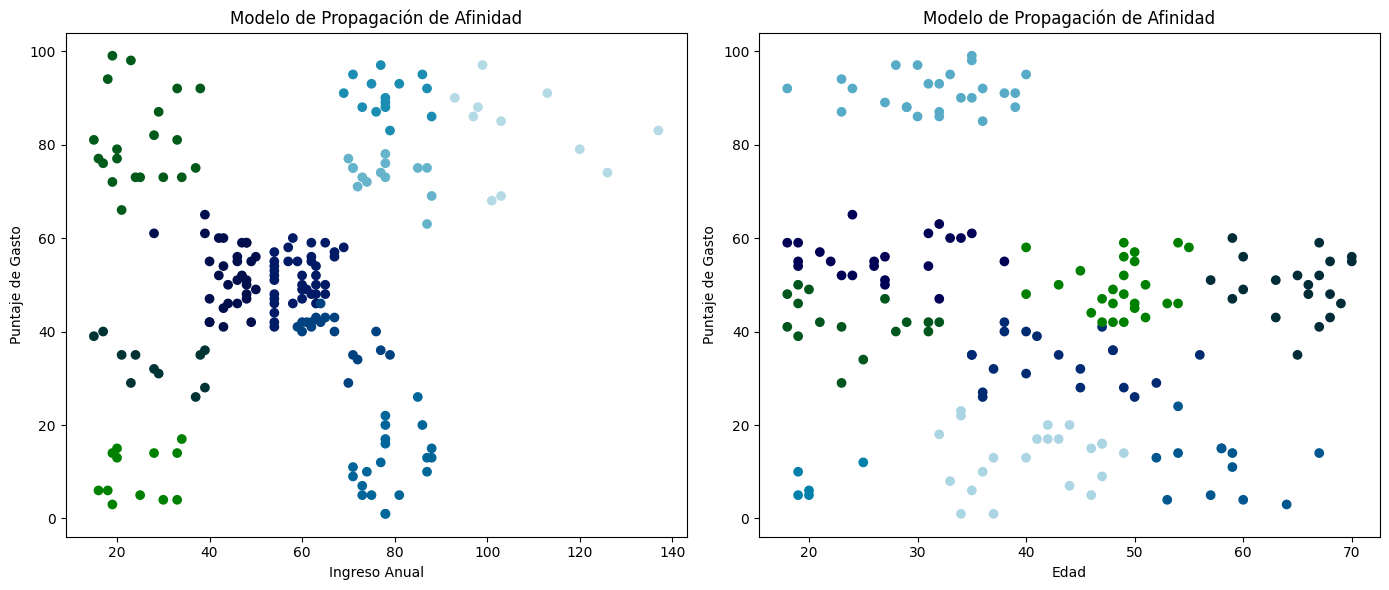

In [168]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Gráfico 1: Ingreso Anual vs Puntaje de Gasto
X1 = dataset.iloc[:, [2, 3]].values
ap1 = AffinityPropagation()
ap_model1 = ap1.fit(X1)
ap_y_pred1 = ap1.predict(X1)

axes[0].scatter(X1[:,0], X1[:,1], c=ap_y_pred1, cmap='ocean')
axes[0].set_title('Modelo de Propagación de Afinidad')
axes[0].set_xlabel('Ingreso Anual')
axes[0].set_ylabel('Puntaje de Gasto')

# Gráfico 2: Edad vs Puntaje de Gasto
X2 = dataset.iloc[:, [1, 3]].values
ap2 = AffinityPropagation()
ap_model2 = ap2.fit(X2)
ap_y_pred2 = ap2.predict(X2)

axes[1].scatter(X2[:,0], X2[:,1], c=ap_y_pred2, cmap='ocean')
axes[1].set_title('Modelo de Propagación de Afinidad')
axes[1].set_xlabel('Edad')
axes[1].set_ylabel('Puntaje de Gasto')

plt.tight_layout()
plt.show()

La figura 15.6 muestra los dos gráficos de agrupación: uno para ingreso anual versus puntaje de gasto y el otro para edad versus puntaje de gasto.

## Resumen

La agrupación por propagación de afinidad se basa en la afinidad que cada punto de datos tiene con todos los demás puntos del conjunto de datos. Cada punto de datos en el conjunto intenta ser un líder para formar su propio grupo. Solo unos pocos tienen éxito, y así es como formamos los grupos o clusters en el conjunto completo.  

El algoritmo funciona creando dos matrices: *responsibility* (responsabilidad) y *availability* (disponibilidad). Ambas matrices se actualizan durante varias iteraciones hasta alcanzar un punto en el que no es posible realizar más agrupaciones. El algoritmo es ciertamente computacionalmente costoso, pero produce resultados excelentes en muchas situaciones, especialmente cuando no se conoce el número de grupos que puede tener un conjunto de datos.  